In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow_probability import distributions as tf_prob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns 

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
class MDN(tf.keras.Model):

    def __init__(self, no_neurons=100, no_components = 2):
        super(MDN, self).__init__(name="MDN")
        self.no_neurons = no_neurons
        self.no_components = no_components
        
        self.hl_1 = Dense(no_neurons, activation="relu", name="hl_1")
        self.hl_2 = Dense(no_neurons, activation="relu", name="hl_2")
        
        self.alpha = Dense(no_components, activation="softmax", name="alpha")
        self.mu = Dense(no_components, activation="nnelu", name="mu")
        self.sigma = Dense(no_components, activation="nnelu", name="sigma")
        self.conc = Concatenate(name="conc")
        
    def call(self, inputs):
        x = self.hl_1(inputs)
        x = self.hl_2(x)
        
        alpha_v = self.alpha(x)
        mu_v = self.mu(x)
        sigma_v = self.sigma(x)
        
        return self.conc([alpha_v, mu_v, sigma_v])
    

In [3]:
def nnelu(input):
    #Calculate non-negative ELU
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def vector_unfold(parameter_vector):
    #Unfold the list of given parameters
    return [parameter_vector[:,i*no_components:(i+1)*no_components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    #Calculate negative log-likelihood
    alpha, mu, sigma = vector_unfold(parameter_vector)
    
    gm = tf_prob.MixtureSameFamily(mixture_distribution=tf_prob.Categorical(probs = alpha),
                               components_distribution=tf_prob.Normal(loc = mu, scale = sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y))
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

#Add activation function to keras
tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [4]:
#Load data from https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set
df = pd.read_excel('real_estate.xlsx')

In [5]:
df.shape

(414, 8)

In [6]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
#Split in train/test
train = df.iloc[:300,]
test = df.iloc[300:,]

x_train = train.drop(['No','X1 transaction date','Y house price of unit area'], axis = 1)
y_train = train['Y house price of unit area']

x_test = test.drop(['No','X1 transaction date','Y house price of unit area'], axis = 1)
y_test = test['Y house price of unit area']

In [8]:
#Scale values
min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x_train) 
x_test = min_max_scaler.transform(x_test) 

### Simple Feed-Forward Neural Network

In [9]:
#Create a simple Feed-Forward Neural Network
model = Sequential()
model.add(Dense(24, input_dim=x_train.shape[1],
                kernel_initializer='normal',
                activation="relu"))
model.add(Dense(1, activation = 'linear'))
model.compile(loss="MeanSquaredError", optimizer='adam')

history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose = 0)

In [10]:
#predict on test set
pred = model.predict(x_test)

In [11]:
#Save to dataframe and compare with real values
results_df = pd.DataFrame({'Real':y_test.values, 'Predicted':[w[0] for w in pred]})
results_df.head()

,Real,Predicted
0,36.9,29.044529
1,35.7,32.995735
2,23.2,29.672832
3,38.4,32.912354
4,29.4,30.934549


In [12]:
results_df.iloc[18]

Real         49.800000
Predicted    39.003418
Name: 18, dtype: float64

### Mixture Density Network

In [13]:
#Select parameters
no_parameters = 3 #Should always be 3: alpha, mu and sigma
no_components = 3 #Choose and tune according to the application
no_neurons = 100 #Hyper-parameter to be tuned

In [14]:
#Compile and train MDN
mdn = MDN(no_neurons=no_neurons, no_components=no_components)
mdn.compile(loss=gnll_loss, optimizer='adam')

mdn.fit(x=x_train, y=y_train,epochs=150, validation_data=(x_test, y_test), batch_size=32, verbose=0)

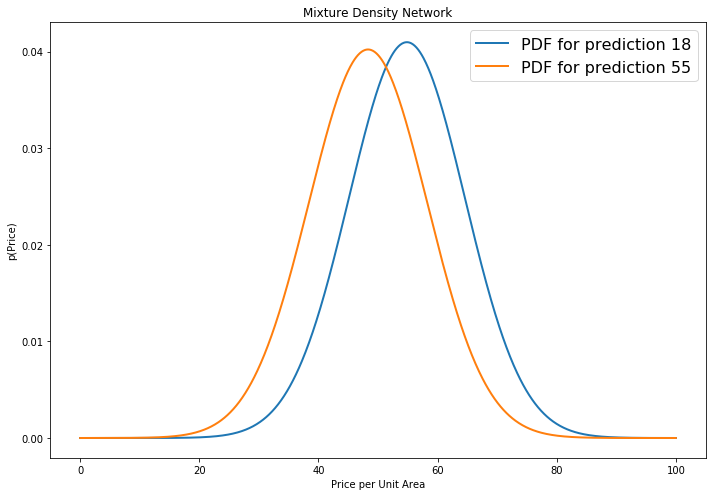

In [15]:
#create plotting function
def plot_rate(ax, index, color_index):
    alpha, mu, sigma = vector_unfold(mdn.predict(x_test[index].reshape(1,-1)))

    gm = tf_prob.MixtureSameFamily(
            mixture_distribution=tf_prob.Categorical(probs=alpha),
            components_distribution=tf_prob.Normal(loc=mu, scale=sigma))
    pyx = gm.prob(x)
    
    ax.plot(x,pyx,alpha=1, color=sns.color_palette()[color_index], linewidth=2, label="PDF for prediction {}".format(index))
    

#Select x values according to the dataset
x = np.linspace(0,100,int(1e3))

plt.figure(figsize=(10,7))
ax = plt.gca()

#Select specific examples to plot
plot_rate(ax, 18,0)
plot_rate(ax, 55,1)

ax.set_xlabel("Price per Unit Area")
ax.set_ylabel("p(Price)")

ax.legend(fontsize=16)
plt.title('Mixture Density Network')
plt.tight_layout()
plt.savefig('pdf_real_estate.jpg')
plt.show()

In [16]:
print('Real Value of observation 18: {}'.format(y_test.iloc[18]))
print('Real Value of observation 55: {}'.format(y_test.iloc[55]))

Real Value of observation 18: 49.8
Real Value of observation 55: 60.7


### Apply to entire dataset

In [17]:
x = np.linspace(0,100,int(1e3)) 

def find_pdf(index):
    alpha, mu, sigma = vector_unfold(mdn.predict(x_test[index].reshape(1,-1)))

    gm = tf_prob.MixtureSameFamily(
            mixture_distribution=tf_prob.Categorical(probs=alpha),
            components_distribution=tf_prob.Normal(
                loc=mu,       
                scale=sigma))
    pyx = gm.prob(x)
    return pyx

In [18]:
all_preds = np.array([find_pdf(0)])
for i in range(1,x_test.shape[0]):
    temp_pred = np.array([find_pdf(i)])
    all_preds = np.concatenate((all_preds, temp_pred), axis=0)

In [22]:
df_all_preds = pd.DataFrame(all_preds.T)
df_all_preds.index = np.round(x,2)
df_all_preds = df_all_preds.sort_index(ascending = False)

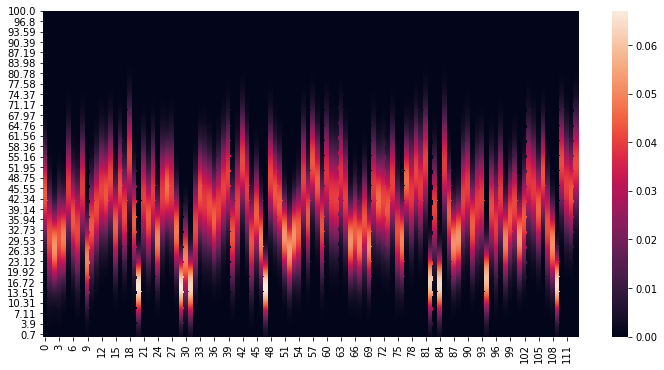

In [23]:
#Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df_all_preds)
plt.savefig('heatmap.jpg')
plt.show()